### Face Recognition Research - Experiments

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd

/content


In [4]:
cd '/content/drive/My Drive/Face Recognition Research'

/content/drive/My Drive/Face Recognition Research


### Importing some neccesary packages

In [5]:
import os
import time
import tqdm 
import tensorflow as tf
import sklearn
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL 
from pathlib import Path

#### Basic intuition (Block Diagram) of what we want to achieve :-

In [6]:
from google.colab import files

In [16]:
files.upload()

Saving fvpresearchblockdiagramv1.png to fvpresearchblockdiagramv1.png


{'fvpresearchblockdiagramv1.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x95\x00\x00\x00\x83\x08\x06\x00\x00\x00\xdcA\xe0\x08\x00\x00\x05\xedtEXtmxfile\x00%3Cmxfile%20host%3D%22app.diagrams.net%22%20modified%3D%222020-12-14T23%3A28%3A51.170Z%22%20agent%3D%225.0%20(Windows%20NT%2010.0%3B%20Win64%3B%20x64)%20AppleWebKit%2F537.36%20(KHTML%2C%20like%20Gecko)%20Chrome%2F87.0.4280.88%20Safari%2F537.36%22%20etag%3D%22Eq4jC2_PxNcKkodjVzQ6%22%20version%3D%2214.0.0%22%20type%3D%22google%22%3E%3Cdiagram%20id%3D%22nanDYL43pd0p5KtfJ5qm%22%20name%3D%22Page-1%22%3E7VdLc5swEP41zLSHZHgYxrnGdtJDOz3k0PQo0AJKBWIkEeP8%2Bq5AvAbcps2jl14I%2B2l3tfp29eE4wa5obiWp8i%2BCAnd8lzZOsHd8%2F2rj49MApw4ItxbIJKMd5I3AHXsCC7oWrRkFNXPUQnDNqjmYiLKERM8wIqU4zt1Swee7ViSDBXCXEL5EvzGq8w7dhu6IfwKW5f3OnmtXCtI7W0DlhIrjBAoOTrCTQujurWh2wA13PS9d3M2Z1aEwCaV%2BToC%2BONwrvtdqI27FQ3kFT1%2B9i6jL8kh4bQ9si9WnnoFMirqybiA1NGu8k7h3d5d1ecNpcUpAFKDlCV36EQm7CDsgfmAzHEe6o8hi%2BZTq3pHYFmdD6pEFfLFE%2FAEp3oKUG5IAInvQeFYmSsePSFE5wXUZK%2FMHbY5lX

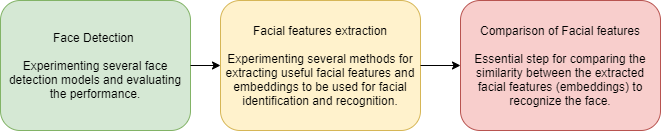



## 01. Face Detection

### What algorithms do we test for Face detection ? What are the fastest and most accurate algorithms for Face detection ?

OPTIONS 
- **Haar Cascade Classifier** (Popular and Already tested in the current codebase in utils.py), It is fast and quite inaccurate especially when the frontal face is not well positioned or with poor resolution images.

- **DLIB HOG Algorithm** (I just checked it out after Arnold discussed on it, it is also very efficient and accurate. Currently used in state-of-the-art face recognition and detection systems).

- **DNN (Deep neural network)** module (What is currently being used in the current API, this uses a deep learning approach based on single-shot detector to solve of the accuracy issues with other approaches like Haar).

- **MTCNN** - (Discovered this from research on FaceNet as discussed by Arnold in the google doc). This has achieved state-of-the-art results on benchmark datasets and has high accuracy regardless of the face orientation and image quality. However, it comes with a performance trade-off against the HOG method. I think this is quite suitable for our use-case.



In [17]:
# Testing the MTCNN approach for Face detection

!mkdir assets

In [7]:
# Install the mtcnn package

!pip install mtcnn

     |████████████████████████████████| 2.3MB 9.4MB/s 


In [8]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.3.0
/device:GPU:0


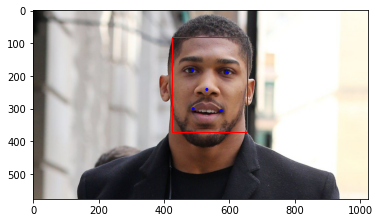

In [15]:
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle

detector = MTCNN()  # Initialize the MTCNN model with default weights, we can also try out other pre-trained weights

FACES_BASE_DIR = "./assets"

def detect_faces(filename):
  img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
  return detector.detect_faces(img)
  
def show_detected_face(filename, label = None, add_face_keypoints = False):
  img = plt.imread(filename, cv2.IMREAD_UNCHANGED)
  plt.imshow(img)
  # Plot axis context
  ax = plt.gca()
  for face in detect_faces(filename):
    x,y,w,h = face['box']
    # Create the rectangle box
    rect = Rectangle((x,y), w, h, fill = False, color = 'red' )
    # Draw the rectangle box
    ax.add_patch(rect)

    if add_face_keypoints:
      for key, value in face["keypoints"].items():
        dot = Circle(value, radius = 3, color = 'blue')
        ax.add_patch(dot)

    if label:
      plt.title(label)

  plt.show()


show_detected_face("./assets/anthonyjoshua01.jpg", add_face_keypoints = True)

###### Cool, the MTCNN model extracts the bounding box of the face and the facial keypoints as you can see above.

In [33]:
%timeit detect_faces("./assets/anthonyjoshua01.jpg")  #Takes 0.671s to detect the face

1 loop, best of 3: 671 ms per loop


In [35]:
print(detect_faces("./assets/anthonyjoshua01.jpg"))

[{'box': [424, 80, 231, 290], 'confidence': 0.99955815076828, 'keypoints': {'left_eye': (488, 182), 'right_eye': (593, 188), 'nose': (531, 241), 'mouth_left': (489, 300), 'mouth_right': (575, 306)}}]


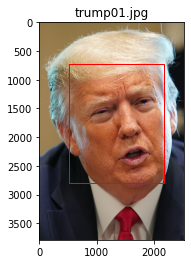

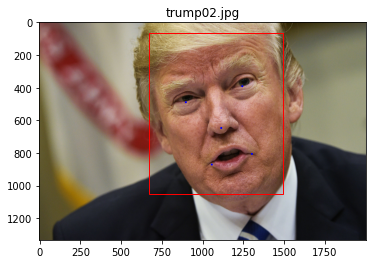

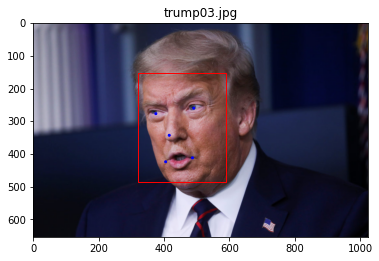

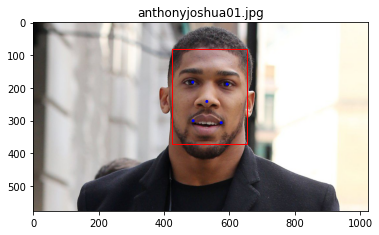

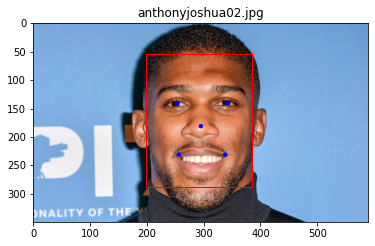

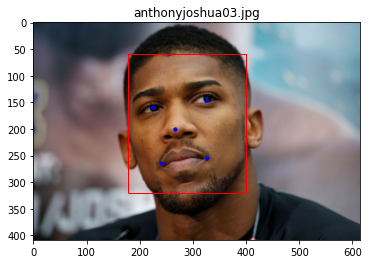

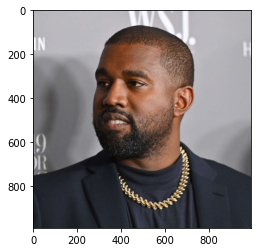

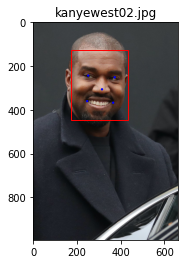

In [16]:
# Testing for all the faces to see how robust the model is :- 
face_list = os.listdir("./assets")

for _ in face_list:
  show_detected_face(os.path.join(FACES_BASE_DIR, _), label = _, add_face_keypoints = True)

#### Nice, despite the orientation of the faces, it still detects some except the Kanye west face (Why though ? The beards ?). We can also test the DNN and HOG algorithm with this to see the performance. 

#### Let's get a dataset of faces, I found one on Kaggle for experimentation or we could create a custom one by scraping Google.

In [17]:
if not os.path.isdir("datasets"):
  os.mkdir("datasets")

if not os.path.isdir("config"):
  os.mkdir("config")

In [23]:
# Downloading the datasets using Kaggle API
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Face Recognition Research/config"

In [26]:
cd datasets

/content/drive/My Drive/Face Recognition Research/datasets


In [31]:
!kaggle datasets download -d dansbecker/5-celebrity-faces-dataset

 99% 5.00M/5.03M [00:00<00:00, 23.2MB/s]
100% 5.03M/5.03M [00:00<00:00, 20.0MB/s]


In [32]:
!ls

5-celebrity-faces-dataset.zip


#### Check [HERE](https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset) for dataset description.

In [ ]:
#Unzipping the zip files to extract the celebrities faces dataset folder and deleting the zip files
!unzip \*.zip  && rm *.zip

In [34]:
!ls

data  train  val


In [39]:
os.listdir('./train')

['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']

In [42]:
for root, dirs, files in os.walk(".", topdown = False):
   for name in dirs:
      print(os.path.join(root, name))

./data/train/ben_afflek
./data/train/elton_john
./data/train/jerry_seinfeld
./data/train/madonna
./data/train/mindy_kaling
./data/val/ben_afflek
./data/val/elton_john
./data/val/jerry_seinfeld
./data/val/madonna
./data/val/mindy_kaling
./data/train
./data/val
./train/ben_afflek
./train/elton_john
./train/jerry_seinfeld
./train/madonna
./train/mindy_kaling
./val/ben_afflek
./val/elton_john
./val/jerry_seinfeld
./val/madonna
./val/mindy_kaling
./data
./train
./val


In [45]:
print(os.listdir("./train/ben_afflek"))

['httpcsvkmeuaeccjpg.jpg', 'httpimagesfandangocomrImageRendererredesignstaticimgnoxportraitjpgpcpcpcimagesmasterrepositoryperformerimagespjpg.jpg', 'httpssmediacacheakpinimgcomxdbbdbbbececacdecdcdfjpg.jpg', 'httpssmediacacheakpinimgcomxdfdfadcfeabjpg.jpg', 'httpssmediacacheakpinimgcomxedaedabcbefbcbabbjpg.jpg', 'httpssmediacacheakpinimgcomxeebdfdbaaajpg.jpg', 'httpssmediacacheakpinimgcomxeeedcacddeccccacfjpg.jpg', 'httpsuploadwikimediaorgwikipediacommonsthumbddBenAffleckbyGageSkidmorejpgpxBenAffleckbyGageSkidmorejpg.jpg', 'httptrwebimgacstanetcxbdddmediasnmediajpg.jpg', 'httpwwwaceshowbizcomimagesphotobenaffleckjpg.jpg', 'httpwwwallposterscomimagesPostersPFjpg.jpg', 'httpwwwfilmscoopitcgibinattoriBENAFFLECKBENAFFLECKjpg.jpg', 'httpwwwhillsindcomstorebenjpg.jpg', 'httpwwwrumenewscomwpcontentuploadsbenafflekxpng.jpg']


##### I think the names are a bit too lengthy, let's do some renaming.

In [50]:
train_faces_dirs = [os.path.join(root, name) for name in dirs  for root, dirs, files in os.walk("./train", topdown = False) if len(dirs) > 0]

In [51]:
train_faces_dirs

['./train/ben_afflek',
 './train/elton_john',
 './train/jerry_seinfeld',
 './train/madonna',
 './train/mindy_kaling']

In [115]:
val_faces_dirs = [os.path.join(root, name) for name in dirs  for root, dirs, files in os.walk("./val", topdown = False) if len(dirs) > 0]

In [116]:
val_faces_dirs

['./val/ben_afflek',
 './val/elton_john',
 './val/jerry_seinfeld',
 './val/madonna',
 './val/mindy_kaling']

In [57]:
for face_images_dir in train_faces_dirs:
  i = 0
  for face_image in os.listdir(face_images_dir):
    os.rename(os.path.join(face_images_dir,face_image), os.path.join(face_images_dir, '{}.jpg'.format(str(i).zfill(3))))
    i += 1

In [58]:
os.listdir(train_faces_dirs[0])

['000.jpg',
 '001.jpg',
 '002.jpg',
 '003.jpg',
 '004.jpg',
 '005.jpg',
 '006.jpg',
 '007.jpg',
 '008.jpg',
 '009.jpg',
 '010.jpg',
 '011.jpg',
 '012.jpg',
 '013.jpg']

In [59]:
# Let's get started with extracting the faces from these images for building the face recognition pipeline

In [207]:
# Helper functions 

def extract_face(path_to_file):
  try:
    img = np.asarray(cv2.imread(path_to_file, cv2.IMREAD_UNCHANGED))
    face_points = detect_faces(path_to_file)
    x,y,w,h = face_points[0]['box']
    # Extracting the ROI (Region of Interest)  for the Face's bounding box
    x1,x2,y1,y2 = abs(x), abs(x+w), abs(y), abs(y+h)
    face = img[y1:y2, x1:x2]
    # print(face)
    face_resized = cv2.resize(face, (160, 160), cv2.INTER_AREA)
    plt.imshow(face_resized)
    return np.asarray(face_resized)
  except: 
    pass

array([[[  2,   5,  10],
        [  2,   5,  10],
        [  2,   6,  10],
        ...,
        [  8,  12,  21],
        [ 10,  13,  21],
        [ 10,  13,  21]],

       [[  2,   5,  10],
        [  2,   5,  10],
        [  2,   5,  10],
        ...,
        [  7,  11,  22],
        [  8,  11,  22],
        [  8,  11,  22]],

       [[  1,   4,   9],
        [  1,   4,   9],
        [  3,   6,  10],
        ...,
        [  3,   8,  27],
        [  4,   8,  26],
        [  4,   8,  26]],

       ...,

       [[211, 206, 201],
        [211, 206, 201],
        [210, 206, 202],
        ...,
        [ 11,   8,  14],
        [ 10,   8,  14],
        [ 10,   8,  14]],

       [[205, 199, 193],
        [205, 199, 193],
        [207, 202, 197],
        ...,
        [ 10,   8,  14],
        [ 10,   8,  14],
        [ 10,   8,  14]],

       [[203, 197, 190],
        [203, 197, 190],
        [206, 201, 195],
        ...,
        [ 10,   8,  14],
        [ 10,   8,  14],
        [ 10,   8,  14]]

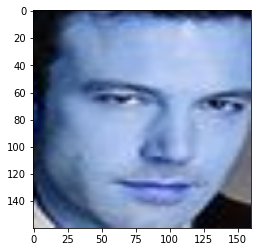

In [208]:
# Testing 
extract_face(os.path.join(train_faces_dirs[0], os.listdir(train_faces_dirs[0])[5]))

In [209]:
# Helper function to load face from a person's folder

def load_face_images(person_dir):
  """ Load and store face images in a directory """
  faces = []
  for img in os.listdir(person_dir):
    path_to_file = os.path.join(person_dir, img)
    face = extract_face(path_to_file)
    if not face is None:
      faces.append(face)

  return faces

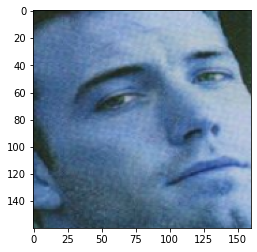

In [210]:
test_faces = load_face_images(train_faces_dirs[0])

[PROCESS] : Loaded 13 faces for ben_afflek
[PROCESS] : Loaded 17 faces for elton_john
[PROCESS] : Loaded 21 faces for jerry_seinfeld
[PROCESS] : Loaded 18 faces for madonna
[PROCESS] : Loaded 21 faces for mindy_kaling


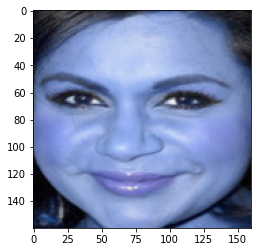

In [211]:
Xtrain, Ytrain = [], []

for person_dir in train_faces_dirs:
  faces = load_face_images(person_dir)
  labels = [person_dir.split("/")[-1] for k in range(len(faces))]
  print(f"[PROCESS] : Loaded {len(faces)} faces for {labels[0]}")
  Xtrain.extend(faces)
  Ytrain.extend(labels)

In [212]:
Xtrain, Ytrain = np.asarray(Xtrain), np.asarray(Ytrain)

In [213]:
Xtrain.shape, Ytrain.shape

((90, 160, 160, 3), (90,))

In [214]:
Ytrain

array(['ben_afflek', 'ben_afflek', 'ben_afflek', 'ben_afflek',
       'ben_afflek', 'ben_afflek', 'ben_afflek', 'ben_afflek',
       'ben_afflek', 'ben_afflek', 'ben_afflek', 'ben_afflek',
       'ben_afflek', 'elton_john', 'elton_john', 'elton_john',
       'elton_john', 'elton_john', 'elton_john', 'elton_john',
       'elton_john', 'elton_john', 'elton_john', 'elton_john',
       'elton_john', 'elton_john', 'elton_john', 'elton_john',
       'elton_john', 'elton_john', 'jerry_seinfeld', 'jerry_seinfeld',
       'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld',
       'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld',
       'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld',
       'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld',
       'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld',
       'jerry_seinfeld', 'jerry_seinfeld', 'jerry_seinfeld',
       'jerry_seinfeld', 'madonna', 'madonna', 'madonna', 'madonna',
       'madonna', 'madonna', 'madonna', 'madonna', 'm

[PROCESS] : Loaded 5 faces for ben_afflek
[PROCESS] : Loaded 4 faces for elton_john
[PROCESS] : Loaded 5 faces for jerry_seinfeld
[PROCESS] : Loaded 4 faces for madonna
[PROCESS] : Loaded 5 faces for mindy_kaling


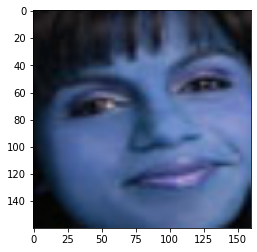

In [255]:

Xtest, Ytest = [], []

for person_dir in val_faces_dirs:

  faces = load_face_images(person_dir)
  labels = [person_dir.split("/")[-1] for k in range(len(faces))]
  print(f"[PROCESS] : Loaded {len(faces)} faces for {labels[0]}")
  Xtest.extend(faces)
  Ytest.extend(labels)

In [256]:
Xtest, Ytest = np.asarray(Xtest), np.asarray(Ytest)

#### Good, succssfully created the training data.

In [257]:
cd ..

/content/drive/My Drive/Face Recognition Research


In [218]:
# Compressing and saving the data

if not os.path.isdir("faces_numpy_data"):
  os.mkdir("faces_numpy_data")

In [219]:
np.savez_compressed("./faces_numpy_data/kaggle_celebs_faces", Xtrain = Xtrain, Ytrain = Ytrain)

In [220]:
np.savez_compressed("./faces_numpy_data/kaggle_celebs_faces_test", Xtest = Xtest, Ytest = Ytest)

### Facial Features extraction from the saved faces

This section will involve extracting the facial features from each face. Facial features are like descriptive features of a person's face which distinguishes it from another person's face. These features are basically points around the eyes, nose, mouth, face contours etc. There are some algorithms and pre-trained models that can be used to extract facial features from faces.

This is a nice image I found online which visually explains this step :- 
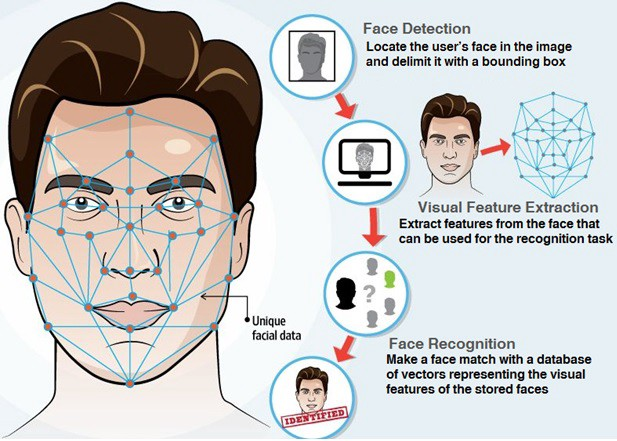


#### Common Algorithms used for Facial features extraction 

- Principal Component Analysis (PCA) and its derivatives
- VGGFace algorithms (Pre-trained model)
- SVM (Support Vector Machine) algorithm
- FaceNet (Most accurate)

###### *An alternative to these algorithms which is usually faster is using some third-party Face Recognition APIs.

In [221]:
# Trying out facenet pre-trained model for extracting facial features/embeddings 
#(We are using a pre-trained model because it is computationally expensive to train a new one and also this was trained by deep learning experts so it will be more accurate)

In [222]:

if not os.path.isdir("models"):
  os.mkdir("models")

In [223]:
# Using the facenet pre-trained model for Keras to get things started (It is also available for Pytorch)

from keras.models import load_model
facenet_model = load_model("./models/facenet_keras.h5")

In [224]:
facenet_model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [225]:
def extract_face_embeddings(face_arr):
  # Normalize the data 
  face_arr = face_arr.astype("float32")
  mean = face_arr.mean()
  std = face_arr.std()
  face_arr = (face_arr - mean) / std 
  return facenet_model.predict(np.expand_dims(face_arr, axis = 0))[0]

In [227]:
# Extract the embeddings for the Xtrain and Xtest 

Xtrain_embeddings = []
for face in Xtrain:
  embeddings = extract_face_embeddings(face)
  Xtrain_embeddings.append(embeddings)

Xtrain_embeddings = np.asarray(Xtrain_embeddings)

In [228]:
Xtrain_embeddings.shape

(90, 128)

In [229]:
Xtest_embeddings = []
for face in Xtest:
  embeddings = extract_face_embeddings(face)
  Xtest_embeddings.append(embeddings)

Xtest_embeddings = np.asarray(Xtest_embeddings)

In [230]:
Xtest_embeddings.shape

(23, 128)

In [231]:
# Saving to compressed file
np.savez_compressed('kaggle_celebrities_data_full_embeddings', Xtrain = Xtrain_embeddings, Xtest = Xtest_embeddings, Ytrain = Ytrain, Ytest = Ytest)

### The final step of the Face recognition pipeline is the feature comparison where the face embedding of a person is compared to another face embedding, and if there is a good similarity, it is regarded as a match. And the person is recognized.

Normal Machine learning algorithms for binary and multi-class classification like Logistic Regression, KNN, Trees, SVM can be suitable for this. However SVM is the most used due to its accurate results when working with face embeddings. This is because SVM scales well with high-dimensional data and the likelihood of over-fitting is lesser. 

Other non-machine learning methods for comparing the similarity between two embeddings include :- 

- Euclidean distance method
- Cosine similarity method

(Both Euclidean and Cosine similarity method are based on the same intuition)

In [232]:
## Trying out Support Vector Machine for the multi-class classification where there are 5 classes in this case

In [234]:
from sklearn.svm import SVC 
from sklearn.preprocessing import LabelEncoder, Normalizer

In [260]:
# Label encoding for the targets (Ytrain and Ytest)
lbl = LabelEncoder()
Ytrain_encoded = lbl.fit_transform(Ytrain)
Ytest_encoded = lbl.fit_transform(Ytest)

In [236]:
Ytrain_encoded

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4])

In [239]:
lbl.classes_

array(['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna',
       'mindy_kaling'], dtype='<U14')

In [243]:
# Normalizing the Face embeddings to prepare it as an input to the SVM model
norm = Normalizer()
norm.fit(Xtrain_embeddings)
Xtrain_embeddings_norm = norm.transform(Xtrain_embeddings)
Xtest_embeddings_norm = norm.transform(Xtest_embeddings)

In [244]:
# Instantiate the svm model with linear kernel

model = SVC(kernel = "linear")

In [245]:
# Fitting the model to the data
model.fit(Xtrain_embeddings_norm, Ytrain_encoded)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [246]:
# Evaluating the performance of the model 
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score 

In [247]:
Ytrain_preds = model.predict(Xtrain_embeddings_norm)
Ytest_preds = model.predict(Xtest_embeddings_norm)

In [261]:
# Accuracy score for train dataset 

print(f"Accuracy score for Train data : {accuracy_score(Ytrain_preds, Ytrain_encoded)*100}%")
print(f"Accuracy score for Test data : {accuracy_score(Ytest_preds, Ytest_encoded)*100}%")

Accuracy score for Train data : 100.0%
Accuracy score for Test data : 100.0%


#### Nice, Accuracy of 100% on both. WHY ?

In [288]:
def test_model(filename):
  face = extract_face(filename)
  face_embeddings = extract_face_embeddings(face)
  prediction = model.predict(face_embeddings.reshape(1,-1))
  plt.imshow(face)
  plt.title(f"Actual : {filename.split('/')[-2]} Predicted : {lbl.inverse_transform(prediction)}")
  return prediction

In [281]:
cd datasets

/content/drive/My Drive/Face Recognition Research/datasets


In [305]:
import random
test_file = os.path.join(val_faces_dirs[2], random.choice(os.listdir(val_faces_dirs[2])))

array([2])

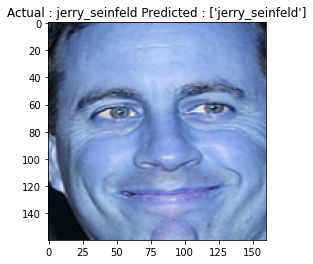

In [306]:
test_model(test_file)

#### Voila, A Face recognition pipeline. This could help us develop a conceptual framework for the problem and benchmark other algorithms we have not tested.

### **REFERENCES**

- [KAGGLE DATASET] :- https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset
- [TECHNICAL WRITE-UP] : https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/
- [PAPER] : https://www.researchgate.net/publication/270018945_A_Review_on_Feature_Extraction_Techniques_in_Face_Recognition
- [PAPER] : https://ieeexplore.ieee.org/abstract/document/9171172